## Data Understanding
a. Import library dan Load Data

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Load dataset
file_path = '/workspaces/codespaces-jupyter/data/processed/harga_sayuran_clean.csv'
data = pd.read_csv(file_path)

# Konversi 'Tanggal Harga' ke datetime, tangani format tanggal yang tidak konsisten
data['Tanggal Harga'] = pd.to_datetime(data['Tanggal Harga'], dayfirst=True, errors='coerce')

# Hapus baris dengan tanggal tidak valid
data = data.dropna(subset=['Tanggal Harga'])

# Ekstrak fitur dari tanggal
data['Year'] = data['Tanggal Harga'].dt.year
data['Month'] = data['Tanggal Harga'].dt.month

data.head()


/tmp/ipykernel_6536/52201325.py:16: UserWarning: Parsing dates in MM/DD/YYYY format when dayfirst=True was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Tanggal Harga'] = pd.to_datetime(data['Tanggal Harga'], dayfirst=True, errors='coerce')


,ID,Jenis Sayuran,Tanggal Harga,Season,Harga Beli Pengepul per Kilogram,Harga Beli Pasar per Kilogram,Year,Month
0,1,Sawi Putih,2021-01-01,Hujan,3452.271603,3752.737482,2021,1
1,2,Cabe Chilli,2021-01-01,Hujan,20762.943610,24271.626950,2021,1
2,3,Cabe Kriting,2021-01-01,Hujan,34203.878890,38963.481980,2021,1
3,4,Cabe Rawit,2021-01-01,Hujan,52807.009800,56674.717880,2021,1
4,5,Kol,2021-01-01,Hujan,1769.608362,2044.366134,2021,1


b. Visualisasi Distribusi Harga

In [ ]:
# Plot distribusi harga pasar untuk setiap jenis sayuran
plt.figure(figsize=(12, 6))
sns.boxplot(x='Jenis Sayuran', y='Harga Beli Pasar per Kilogram', data=data)
plt.title('Distribusi Harga Pasar untuk Setiap Jenis Sayuran')
plt.xticks(rotation=45)
plt.show()


c. Visualisasi Tren Musiman

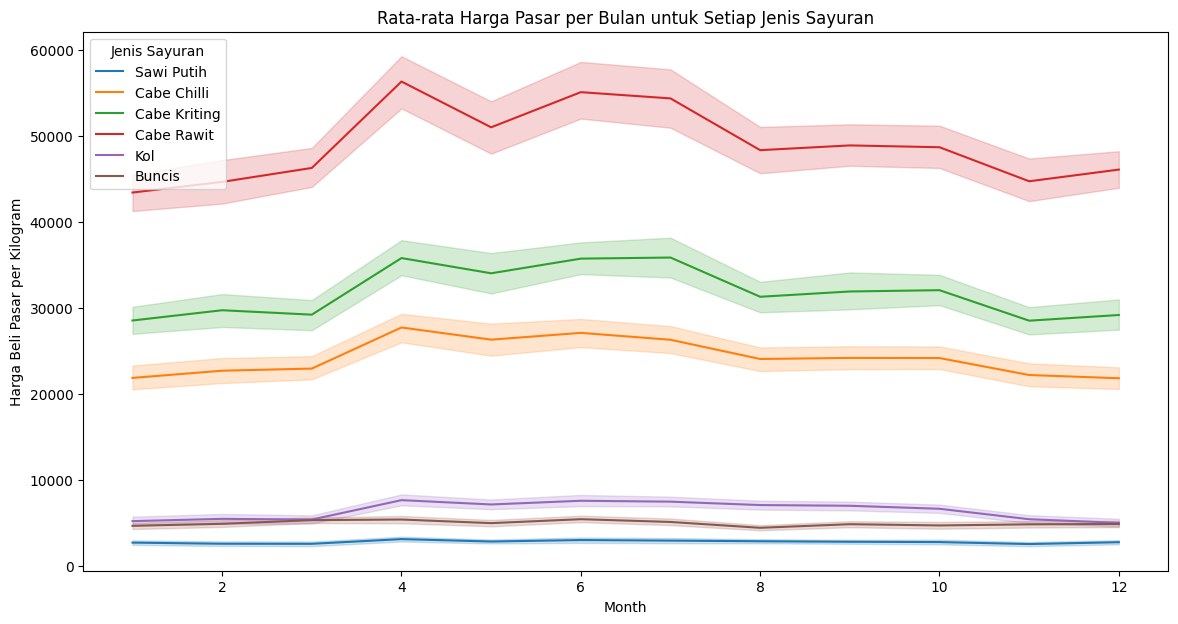

In [3]:
# Plot rata-rata harga pasar per bulan untuk setiap jenis sayuran
plt.figure(figsize=(14, 7))
sns.lineplot(x='Month', y='Harga Beli Pasar per Kilogram', hue='Jenis Sayuran', data=data)
plt.title('Rata-rata Harga Pasar per Bulan untuk Setiap Jenis Sayuran')
plt.show()


d.  Visualisasi Tren Harga dari Waktu ke Waktu

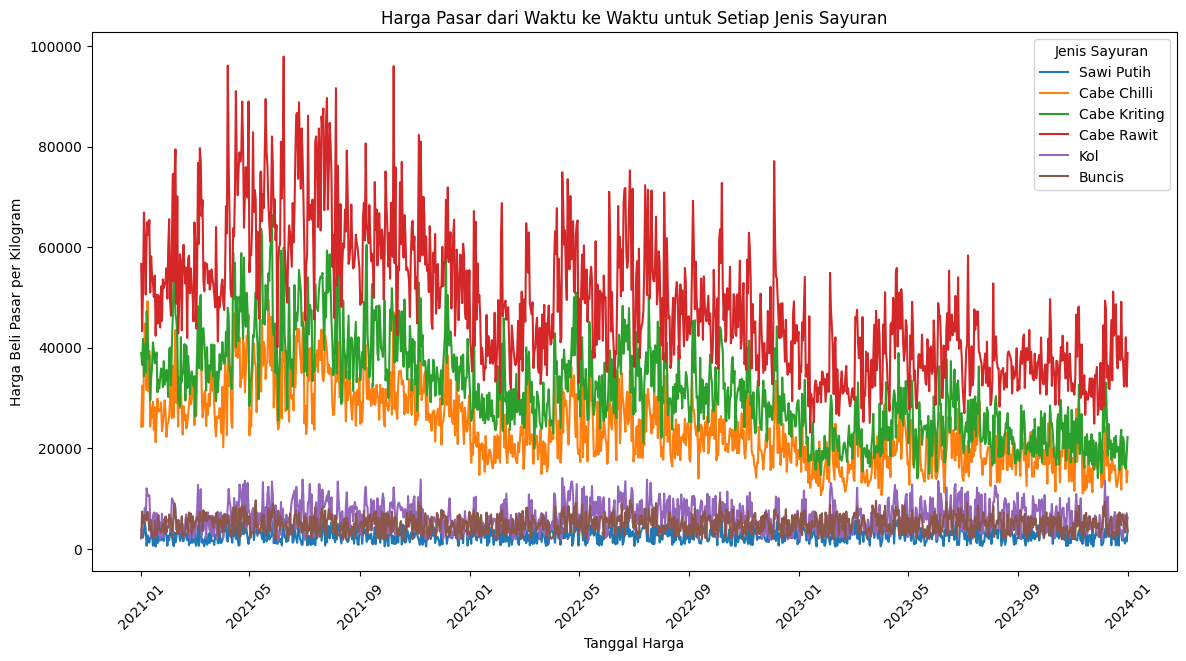

In [4]:
# Plot harga pasar dari waktu ke waktu untuk setiap jenis sayuran
plt.figure(figsize=(14, 7))
sns.lineplot(x='Tanggal Harga', y='Harga Beli Pasar per Kilogram', hue='Jenis Sayuran', data=data)
plt.title('Harga Pasar dari Waktu ke Waktu untuk Setiap Jenis Sayuran')
plt.xticks(rotation=45)
plt.show()


## Data Preparation

a. Feature Engineering

In [5]:
# Konversi 'Tanggal Harga' ke datetime, tangani format tanggal yang tidak konsisten
data['Tanggal Harga'] = pd.to_datetime(data['Tanggal Harga'], dayfirst=True, errors='coerce')

# Hapus baris dengan tanggal tidak valid
data = data.dropna(subset=['Tanggal Harga'])

# Ekstrak fitur dari tanggal
data['Year'] = data['Tanggal Harga'].dt.year
data['Month'] = data['Tanggal Harga'].dt.month
data['Day'] = data['Tanggal Harga'].dt.day
data['DayOfWeek'] = data['Tanggal Harga'].dt.dayofweek
data['Quarter'] = data['Tanggal Harga'].dt.quarter
data['IsWeekend'] = data['DayOfWeek'].isin([5, 6]).astype(int)

# Tambahkan fitur lagged
data['Harga_Bulan_Lalu'] = data.groupby('Jenis Sayuran')['Harga Beli Pasar per Kilogram'].shift(1)
data['Harga_Tahun_Lalu'] = data.groupby('Jenis Sayuran')['Harga Beli Pasar per Kilogram'].shift(12)

# Tambahkan fitur rolling statistics
data['Rolling_Mean_3'] = data.groupby('Jenis Sayuran')['Harga Beli Pasar per Kilogram'].transform(lambda x: x.rolling(window=3).mean())
data['Rolling_Std_3'] = data.groupby('Jenis Sayuran')['Harga Beli Pasar per Kilogram'].transform(lambda x: x.rolling(window=3).std())
data['Rolling_Median_3'] = data.groupby('Jenis Sayuran')['Harga Beli Pasar per Kilogram'].transform(lambda x: x.rolling(window=3).median())

# Definisikan tanggal hari raya Idul Fitri dan Idul Adha
idul_fitri_dates = pd.to_datetime(['2021-05-13', '2022-05-02', '2023-04-21'])
idul_adha_dates = pd.to_datetime(['2021-07-20', '2022-07-09', '2023-06-28'])

# Fungsi untuk menghitung jarak ke hari raya terdekat
def days_to_nearest_holiday(date, holidays):
    return (holidays - date).days[np.abs((holidays - date).days).argmin()]

# Tambahkan fitur hari raya
data['Is_IdulFitri'] = data['Tanggal Harga'].isin(idul_fitri_dates).astype(int)
data['Is_IdulAdha'] = data['Tanggal Harga'].isin(idul_adha_dates).astype(int)
data['Days_To_IdulFitri'] = data['Tanggal Harga'].apply(lambda x: days_to_nearest_holiday(x, idul_fitri_dates))
data['Days_To_IdulAdha'] = data['Tanggal Harga'].apply(lambda x: days_to_nearest_holiday(x, idul_adha_dates))

# Hapus baris dengan NaN setelah penambahan fitur
data = data.dropna()

# Buat interaksi antar fitur yang relevan
data['Year_Month'] = data['Year'] * data['Month']
data['Year_Season'] = data['Year'].astype(str) + '_' + data['Season']

# One-hot encode variabel kategorik
data = pd.get_dummies(data, columns=['Jenis Sayuran', 'Season'])

# Tampilan data hasil feature engineering
data.head()

,ID,Tanggal Harga,Harga Beli Pengepul per Kilogram,Harga Beli Pasar per Kilogram,Year,Month,Day,DayOfWeek,Quarter,IsWeekend,...,Year_Month,Year_Season,Jenis Sayuran_Buncis,Jenis Sayuran_Cabe Chilli,Jenis Sayuran_Cabe Kriting,Jenis Sayuran_Cabe Rawit,Jenis Sayuran_Kol,Jenis Sayuran_Sawi Putih,Season_Hujan,Season_Kemarau
72,73,2021-01-13,2653.947616,2971.743857,2021,1,13,2,1,0,...,2021,2021_Hujan,0,0,0,0,0,1,1,0
73,74,2021-01-13,24265.777370,26161.363330,2021,1,13,2,1,0,...,2021,2021_Hujan,0,1,0,0,0,0,1,0
74,75,2021-01-13,33056.789240,36387.771010,2021,1,13,2,1,0,...,2021,2021_Hujan,0,0,1,0,0,0,1,0
75,76,2021-01-13,46870.759640,54310.500730,2021,1,13,2,1,0,...,2021,2021_Hujan,0,0,0,1,0,0,1,0
76,77,2021-01-13,2122.841107,2286.848301,2021,1,13,2,1,0,...,2021,2021_Hujan,0,0,0,0,1,0,1,0


In [ ]:
# Matriks Korelasi
plt.figure(figsize=(16, 12))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Matriks Korelasi')
plt.show()



In [6]:
# Pair Plot untuk beberapa fitur yang dipilih
selected_features = ['Harga Beli Pasar per Kilogram', 'Year', 'Month', 'DayOfWeek', 'IsWeekend', 'Harga_Bulan_Lalu', 'Harga_Tahun_Lalu']
sns.pairplot(data[selected_features])
plt.show()


In [ ]:
# Distribusi Harga Beli Pasar per Kilogram
plt.figure(figsize=(10, 6))
sns.histplot(data['Harga Beli Pasar per Kilogram'], bins=30, kde=True)
plt.title('Distribusi Harga Beli Pasar per Kilogram')
plt.show()



In [ ]:
# Scatter Plot untuk Harga Beli Pasar per Kilogram terhadap Harga_Bulan_Lalu
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Harga_Bulan_Lalu', y='Harga Beli Pasar per Kilogram', data=data)
plt.title('Scatter Plot Harga Beli Pasar per Kilogram terhadap Harga Bulan Lalu')
plt.show()

a. Train Data

In [ ]:
# Pisahkan fitur dan target
features = numerical_features.drop(['Harga Beli Pasar per Kilogram'], axis=1)
target = numerical_features['Harga Beli Pasar per Kilogram']

# Bagi dataset menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standarisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



## Modeling

a. Original Model SVR

In [ ]:
# Latih model SVR tanpa hyperparameter tuning
original_svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
original_svr.fit(X_train_scaled, y_train)

# Prediksi harga pada data uji dengan model original
y_pred_original = original_svr.predict(X_test_scaled)

b. Hyperparameter Tuning dengan GridSearchCV

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter distribution
# Hyperparameter tuning dengan GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'epsilon': [0.1, 0.2, 0.5, 0.3],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVR(), param_grid, refit=True, verbose=2, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Model terbaik setelah tuning
best_svr = grid_search.best_estimator_

# Prediksi harga pada data uji dengan model yang sudah di-tuning
y_pred_tuned = best_svr.predict(X_test_scaled)

# Best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

# Get the best model
best_svr = random_search.best_estimator_

# Make predictions on the test set
y_pred_best_svr = best_svr.predict(X_test_scaled)


b. Latih Model Gradient Boosting sebagai Pembanding

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Inisialisasi model GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Latih model
gb.fit(X_train_scaled, y_train)

# Buat prediksi pada set pengujian
y_pred_gb = gb.predict(X_test_scaled)


## Evaluation

a. Hitung Metrik Evaluasi untuk Kedua Model

In [ ]:
# Evaluasi model
mae_original = mean_absolute_error(y_test, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test, y_pred_original))
r2_original = r2_score(y_test, y_pred_original)

mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("Original Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_original}")
print(f"Root Mean Squared Error (RMSE): {rmse_original}")
print(f"R-squared (R2): {r2_original}")

print("\nTuned Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_tuned}")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned}")
print(f"R-squared (R2): {r2_tuned}")

b. Perhitungan Manual Metrik

$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

In [ ]:
# Contoh perhitungan manual MSE untuk beberapa data
n = 10  # Jumlah data yang akan digunakan
mse_manual = sum((y_test.values[:n] - y_pred_best_svr[:n]) ** 2) / n
print(f"Manual MSE (contoh): {mse_manual}")

$$ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}i)^2}{\sum{i=1}^{n} (y_i - \bar{y})^2}$$ 

In [ ]:
# Contoh perhitungan manual R² untuk beberapa data
y_mean = y_test.values[:n].mean()
ss_total = sum((y_test.values[:n] - y_mean) ** 2)
ss_res = sum((y_test.values[:n] - y_pred_best_svr[:n]) ** 2)
r2_manual = 1 - (ss_res / ss_total)
print(f"Manual R² (contoh): {r2_manual}")

c. Viualisasi Metrik Evaluasi

In [ ]:
# Visualisasi MSE
plt.figure(figsize=(8, 5))
sns.barplot(x=['SVR', 'Gradient Boosting'], y=[mse_best_svr, mse_gb])
plt.title('Mean Squared Error')
plt.ylabel('Value')
plt.show()

In [ ]:
# Visualisasi R-squared
plt.figure(figsize=(8, 5))
sns.barplot(x=['SVR', 'Gradient Boosting'], y=[r2_best_svr, r2_gb])
plt.title('R-squared')
plt.ylabel('Value')
plt.show()

d. Plot harga Aktual vs Prediksi 

In [ ]:
# Gabungkan data aktual dan prediksi untuk SVR
results_svr = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_best_svr,
    'Year': test_data['Year'],
    'Month': test_data['Month'],
    'Jenis Sayuran': test_data.filter(like='Jenis Sayuran_').idxmax(axis=1).str.replace('Jenis Sayuran_', '')
})

results_svr['Tanggal Harga'] = pd.to_datetime(results_svr['Year'].astype(str) + '-' + results_svr['Month'].astype(str) + '-01')

# Plot harga aktual vs prediksi untuk SVR
plt.figure(figsize=(14, 7))

# Plot harga aktual
sns.lineplot(data=results_svr, x='Tanggal Harga', y='Actual', hue='Jenis Sayuran', marker='o', legend=False)

# Plot harga prediksi
sns.lineplot(data=results_svr, x='Tanggal Harga', y='Predicted', hue='Jenis Sayuran', marker='x', linestyle='--')

# Sesuaikan judul dan label
plt.title('Harga Aktual vs Prediksi (SVR)')
plt.ylabel('Price (IDR)')
plt.xlabel('Date')
plt.xticks(rotation=45)

# Tampilkan legenda
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:len(results_svr['Jenis Sayuran'].unique())], labels[0:len(results_svr['Jenis Sayuran'].unique())])

plt.show()


## Deployment

a. Simpan Model Terbaik (SVR)

In [ ]:
import joblib

# Simpan model dan scaler
joblib.dump(original_svr, 'original_svr_model.pkl')
joblib.dump(best_svr, 'best_svr_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


b. Buat Data untuk Prediksi Masa Depan (Setiap 3 Bulan Sekali)

In [ ]:
import pandas as pd

# Membuat tanggal masa depan untuk setiap 3 bulan di tahun 2024
future_dates = pd.date_range(start='2024-01-01', periods=4, freq='3M')

# Daftar jenis sayuran
vegetables = data['Jenis Sayuran'].unique()

# Menghasilkan dataset untuk prediksi masa depan
forecast_results = pd.DataFrame()

for vegetable in vegetables:
    future_data_list = []
    for date in future_dates:
        season = 'Kemarau' if date.month in [6, 7, 8, 9] else 'Hujan'
        future_data_list.append({
            'Year': date.year,
            'Month': date.month,
            'Jenis Sayuran': vegetable,
            'Season': season,
            'Tanggal Harga': date
        })

    future_data = pd.DataFrame(future_data_list)

    # One-hot encode variabel kategorikal
    future_data_encoded = pd.get_dummies(future_data)
    future_data_encoded = future_data_encoded.reindex(columns=X_train.columns, fill_value=0)

    # Standarisasi fitur
    future_data_scaled = scaler.transform(future_data_encoded)

    # Membuat prediksi untuk data masa depan
    future_predictions = best_svr.predict(future_data_scaled)

    # Menyiapkan hasil untuk dashboard
    forecast = pd.DataFrame({
        'Tanggal Harga': future_data['Tanggal Harga'],
        'Jenis Sayuran': vegetable,
        'Harga Beli Pasar per Kilogram': future_predictions
    })

    forecast_results = pd.concat([forecast_results, forecast])

# Menyimpan hasil prediksi ke dalam file CSV
forecast_results.to_csv('forecast_results.csv', index=False)


In [ ]:
# Tentukan sayuran terbaik berdasarkan harga rata-rata tertinggi
best_vegetable = forecast_results.groupby('Jenis Sayuran')['Harga Beli Pasar per Kilogram'].mean().idxmax()
best_vegetable


In [ ]:
# Tentukan harga tertinggi dari sayuran terbaik
best_price_performance = forecast_results.groupby('Jenis Sayuran')['Harga Beli Pasar per Kilogram'].mean().max()
best_price_performance


In [ ]:
# Hitung deviasi standar harga untuk setiap jenis sayuran
std_prices = forecast_results.groupby('Jenis Sayuran')['Harga Beli Pasar per Kilogram'].std()

# Tentukan sayuran yang direkomendasikan untuk ditanam (dengan deviasi standar terendah)
to_plant = std_prices.nsmallest(2).index.tolist()

# Tentukan sayuran yang sebaiknya dihindari (dengan deviasi standar tertinggi)
to_avoid = std_prices.nlargest(2).index.tolist()

# Simpan informasi tambahan
additional_info = {
    'best_vegetable': forecast_results.groupby('Jenis Sayuran')['Harga Beli Pasar per Kilogram'].mean().idxmax(),
    'best_price_performance': forecast_results.groupby('Jenis Sayuran')['Harga Beli Pasar per Kilogram'].mean().max(),
    'seasons': {
        'Januari - Maret': 'Musim Hujan',
        'April - Juni': 'Transisi ke Musim Kemarau',
        'Juli - September': 'Musim Kemarau',
        'Oktober - Desember': 'Transisi ke Musim Hujan'
    },
    'plant_recommendations': {
        'to_plant': to_plant,
        'to_avoid': to_avoid
    }
}

# Simpan informasi tambahan ke file pkl
joblib.dump(additional_info, 'additional_info.pkl')